In [ ]:
!pip install kaggle pretty_midi torch torchvision torchaudio scikit-learn matplotlib tqdm transformers datasets accelerate -q

from google.colab import drive
drive.mount('/content/drive')

import os, re, json, glob, zipfile, random, warnings, shutil
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

warnings.filterwarnings("ignore")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
FILE_ID = "1VPx3nKsEPR-GV9v0QiNZRbA_Ptdt7lsA"   # ID ZIP gabungan (punyamu)
ZIP_PATH = Path("/content/dataset_mirex.zip")
EXTRACT_DIR = Path("/content/dataset_mirex/")    # root ekstraksi

DRIVE_DATASET_DIR = Path("/content/drive/MyDrive/dataset_mirex")
SAVE_DIR = DRIVE_DATASET_DIR / "liriktrainY"   # folder save
SAVE_DIR.mkdir(parents=True, exist_ok=True)

import gdown
if not ZIP_PATH.exists():
    print("Downloading ZIP via gdown...")
    gdown.download(id=FILE_ID, output=str(ZIP_PATH), quiet=False)
else:
    print("ZIP already exists:", ZIP_PATH)

print("Extracting ZIP ...")
EXTRACT_DIR.mkdir(parents=True, exist_ok=True)
with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
    zf.extractall(EXTRACT_DIR)

print("Done extract.")
print("EXTRACT_DIR content:")
for p in EXTRACT_DIR.iterdir():
    print(" -", p)


ZIP already exists: /content/dataset_mirex.zip
Extracting ZIP ...
Done extract.
EXTRACT_DIR content:
 - /content/dataset_mirex/dataset
 - /content/dataset_mirex/best_lyrics_bert.pt
 - /content/dataset_mirex/README.txt


In [ ]:
master_tracks = pd.read_csv(DRIVE_DATASET_DIR / "master_tracks.csv")
split_global  = pd.read_csv(DRIVE_DATASET_DIR / "split_global.csv")

print("master_tracks:", master_tracks.shape)
print("split_global :", split_global.shape)
master_tracks.head()


master_tracks: (903, 8)
split_global : (903, 2)


,file_id,file_id_norm,emotion,label_id,label_idx,has_audio,has_lyrics,has_midi
0,1,1,Cluster 1,1,0,1,1,0
1,2,2,Cluster 1,1,0,1,0,0
2,3,3,Cluster 1,1,0,1,1,0
3,4,4,Cluster 1,1,0,1,1,1
4,5,5,Cluster 1,1,0,1,0,0


In [ ]:
from pathlib import Path

DATASET_ROOT = EXTRACT_DIR  # /content/dataset_mirex

# === Folder lirik yg bener: /content/dataset_mirex/dataset/Lyrics/ ===
LYRIC_DIR = DATASET_ROOT / "dataset" / "Lyrics"
print("LYRIC_DIR:", LYRIC_DIR)
print("Contoh file lirik:", list(LYRIC_DIR.glob("*.txt"))[:10])

# Gabung master_tracks dengan split_global
df = master_tracks.merge(split_global, left_on="file_id_norm", right_on="id", how="inner")

# Filter hanya lagu yang punya lirik
df_lyrics = df[df["has_lyrics"] == 1].copy()
print("Jumlah lagu yang punya lirik:", len(df_lyrics))

# 🔧 PERBAIKAN UTAMA:
# 1) pakai .txt, bukan .mp3
# 2) pakai {int(x):03d} sesuai formatmu (001.txt, 002.txt, dst.)
def fid_to_lyrics_path(x):
    # kalau ternyata filenya 1.txt bukan 001.txt, kita fallback otomatis
    p_pad   = LYRIC_DIR / f"{int(x):03d}.txt"   # 001.txt
    p_plain = LYRIC_DIR / f"{int(x)}.txt"       # 1.txt
    if p_pad.exists():
        return p_pad
    elif p_plain.exists():
        return p_plain
    else:
        # kalau dua-duanya gak ada, tetap balikin yg padded biar kelihatan di missing list
        return p_pad

df_lyrics["lyrics_path"] = df_lyrics["file_id"].apply(fid_to_lyrics_path)

# Cek apakah ada file yang hilang
missing = [p for p in df_lyrics["lyrics_path"] if not p.exists()]
print("Missing lyrics files:", len(missing))
if missing:
    print("Contoh missing:", missing[:10])


LYRIC_DIR: /content/dataset_mirex/dataset/Lyrics
Contoh file lirik: [PosixPath('/content/dataset_mirex/dataset/Lyrics/313.txt'), PosixPath('/content/dataset_mirex/dataset/Lyrics/175.txt'), PosixPath('/content/dataset_mirex/dataset/Lyrics/545.txt'), PosixPath('/content/dataset_mirex/dataset/Lyrics/587.txt'), PosixPath('/content/dataset_mirex/dataset/Lyrics/234.txt'), PosixPath('/content/dataset_mirex/dataset/Lyrics/096.txt'), PosixPath('/content/dataset_mirex/dataset/Lyrics/732.txt'), PosixPath('/content/dataset_mirex/dataset/Lyrics/825.txt'), PosixPath('/content/dataset_mirex/dataset/Lyrics/290.txt'), PosixPath('/content/dataset_mirex/dataset/Lyrics/398.txt')]
Jumlah lagu yang punya lirik: 764
Missing lyrics files: 0


In [ ]:
def read_txt(path: Path):
    try:
        with open(path, "r", encoding="utf-8", errors="ignore") as f:
            return f.read()
    except Exception:
        return ""

df_lyrics["text"] = df_lyrics["lyrics_path"].apply(read_txt)

# Label 0..4
if "label_idx" in df_lyrics.columns:
    df_lyrics["label"] = df_lyrics["label_idx"].astype(int)
else:
    df_lyrics["label"] = df_lyrics["label_id"].astype(int) - 1

# Buang baris yang teksnya kosong
df_lyrics = df_lyrics[df_lyrics["text"].str.strip() != ""].reset_index(drop=True)

print(df_lyrics[["file_id", "emotion", "label_id", "label", "split"]].head())
print("Distribusi label (0..4) di semua lirik:")
print(df_lyrics["label"].value_counts().sort_index())

train_df = df_lyrics[df_lyrics["split"] == "train"].reset_index(drop=True)
val_df   = df_lyrics[df_lyrics["split"] == "val"].reset_index(drop=True)
test_df  = df_lyrics[df_lyrics["split"] == "test"].reset_index(drop=True)

print("Train lyrics:", len(train_df))
print("Val   lyrics:", len(val_df))
print("Test  lyrics:", len(test_df))

print("\nDistribusi label train:")
print(train_df["label"].value_counts().sort_index())
print("\nDistribusi label val:")
print(val_df["label"].value_counts().sort_index())
print("\nDistribusi label test:")
print(test_df["label"].value_counts().sort_index())


   file_id    emotion  label_id  label  split
0        1  Cluster 1         1      0  train
1        3  Cluster 1         1      0  train
2        4  Cluster 1         1      0  train
3        7  Cluster 1         1      0  train
4        8  Cluster 1         1      0  train
Distribusi label (0..4) di semua lirik:
label
0    135
1    138
2    192
3    173
4    126
Name: count, dtype: int64
Train lyrics: 609
Val   lyrics: 79
Test  lyrics: 76

Distribusi label train:
label
0    110
1    110
2    153
3    137
4     99
Name: count, dtype: int64

Distribusi label val:
label
0    13
1    14
2    20
3    18
4    14
Name: count, dtype: int64

Distribusi label test:
label
0    12
1    14
2    19
3    18
4    13
Name: count, dtype: int64


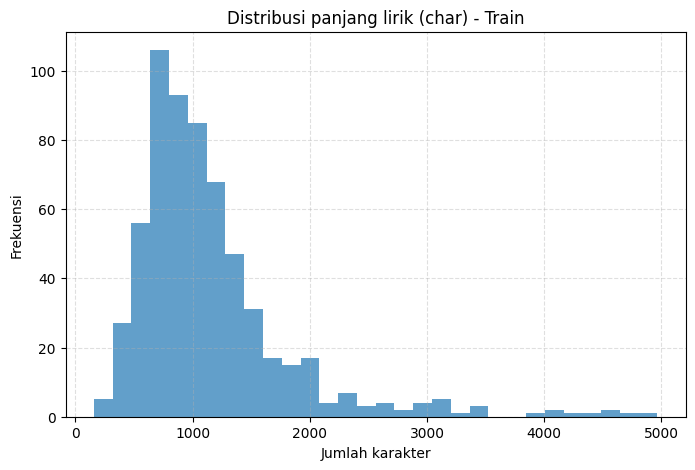

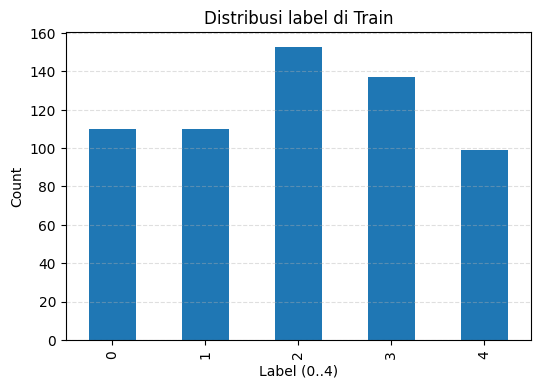

In [ ]:
# panjang lirik (char)
for d in [train_df, val_df, test_df]:
    d["text_len_char"] = d["text"].str.len()

plt.figure(figsize=(8,5))
plt.hist(train_df["text_len_char"], bins=30, alpha=0.7)
plt.title("Distribusi panjang lirik (char) - Train")
plt.xlabel("Jumlah karakter")
plt.ylabel("Frekuensi")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

plt.figure(figsize=(6,4))
train_df["label"].value_counts().sort_index().plot(kind="bar")
plt.title("Distribusi label di Train")
plt.xlabel("Label (0..4)")
plt.ylabel("Count")
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.show()


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import numpy as np
from tqdm import tqdm

# =========================================================
# 1. Seed
# =========================================================
def set_seed(seed=123):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(123)

# =========================================================
# 2. Config & tokenizer
# =========================================================
MODEL_NAME = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

MAX_LEN = 256
BATCH_SIZE = 8
NUM_CLASSES = 5

# =========================================================
# 3. Dataset & DataLoader
# =========================================================
class LyricsDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.texts = df["text"].tolist()
        self.labels = df["label"].tolist()
        self.ids = df["id"].tolist()   # id dari split_global
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text  = self.texts[idx]
        label = self.labels[idx]
        id_   = self.ids[idx]

        enc = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
            "id": id_
        }

# pastikan kolom 'id' ada
for d in [train_df, val_df, test_df]:
    assert "id" in d.columns, "Kolom 'id' harus ada (dari split_global.id)"

train_dataset = LyricsDataset(train_df, tokenizer, MAX_LEN)
val_dataset   = LyricsDataset(val_df, tokenizer, MAX_LEN)
test_dataset  = LyricsDataset(test_df, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

# =========================================================
# 4. Model + optimizer + loss + scheduler
# =========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_CLASSES
).to(device)

# 👉 TIDAK di-freeze lagi, biarkan semua layer trainable
print("✅ All encoder layers are trainable (no freezing).")

# class weights (imbalance-aware)
y_train = train_df["label"].to_numpy()
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class weights:", class_weights)

# pisahkan parameter encoder vs classifier head
encoder_params = []
head_params = []

for name, param in model.named_parameters():
    if "classifier" in name:
        head_params.append(param)
    else:
        encoder_params.append(param)

optimizer = torch.optim.AdamW(
    [
        {"params": encoder_params, "lr": 1e-5},   # encoder: pelan tapi tidak terlalu kecil
        {"params": head_params,    "lr": 2e-5},   # head: lebih kencang
    ],
    weight_decay=0.01,
)

# loss dengan label smoothing kecil
try:
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)
    print("✅ Using CrossEntropyLoss with label_smoothing=0.05")
except TypeError:
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    print("⚠️ label_smoothing tidak didukung versi PyTorch ini, pakai CE biasa.")

EPOCHS = 10
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)


Device: cuda


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Frozen lower encoder layers (0–7)
Class weights: tensor([1.1073, 1.1073, 0.7961, 0.8891, 1.2303], device='cuda:0')
✅ Using CrossEntropyLoss with label_smoothing=0.1


In [ ]:

# =========================================================
# 5. Train & eval functions
# =========================================================
def train_one_epoch(model, loader, optimizer, scheduler, criterion, device, max_grad_norm=1.0):
    model.train()
    all_labels, all_preds, losses = [], [], []

    for batch in tqdm(loader, desc="Train", leave=False):
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits  = outputs.logits
        loss    = criterion(logits, labels)
        loss.backward()

        # gradient clipping biar training lebih stabil
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()
        scheduler.step()

        losses.append(loss.item())
        preds = torch.argmax(logits, dim=-1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    avg_loss = np.mean(losses)
    acc  = accuracy_score(all_labels, all_preds)
    f1   = f1_score(all_labels, all_preds, average="macro")
    prec = precision_score(all_labels, all_preds, average="macro", zero_division=0)
    rec  = recall_score(all_labels, all_preds, average="macro", zero_division=0)
    return avg_loss, acc, f1, prec, rec


def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    all_labels, all_preds, losses = [], [], []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Val", leave=False):
            input_ids      = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels         = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits  = outputs.logits
            loss    = criterion(logits, labels)

            losses.append(loss.item())
            preds = torch.argmax(logits, dim=-1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    avg_loss = np.mean(losses)
    acc  = accuracy_score(all_labels, all_preds)
    f1   = f1_score(all_labels, all_preds, average="macro")
    prec = precision_score(all_labels, all_preds, average="macro", zero_division=0)
    rec  = recall_score(all_labels, all_preds, average="macro", zero_division=0)
    return avg_loss, acc, f1, prec, rec


In [ ]:
history = {
    "train_loss": [], "val_loss": [],
    "train_acc": [],  "val_acc": [],
    "train_f1": [],   "val_f1": [],
    "train_prec": [], "val_prec": [],
    "train_rec": [],  "val_rec": [],
    "lr": []
}

best_val_f1 = -1
patience = 4
patience_counter = 0

BEST_MODEL_PATH = DATASET_ROOT / "best_lyrics_bert.pt"  # nama file biar cocok dgn kode simpanmu

for epoch in range(1, EPOCHS + 1):
    print(f"\n=== Epoch {epoch}/{EPOCHS} ===")

    train_loss, train_acc, train_f1, train_prec, train_rec = train_one_epoch(
        model, train_loader, optimizer, scheduler, criterion, device
    )
    val_loss, val_acc, val_f1, val_prec, val_rec = eval_one_epoch(
        model, val_loader, criterion, device
    )

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["train_f1"].append(train_f1)
    history["val_f1"].append(val_f1)
    history["train_prec"].append(train_prec)
    history["val_prec"].append(val_prec)
    history["train_rec"].append(train_rec)
    history["val_rec"].append(val_rec)
    history["lr"].append(optimizer.param_groups[0]["lr"])

    print(f"Train loss : {train_loss:.4f} | acc: {train_acc:.4f} | F1: {train_f1:.4f} "
          f"| prec: {train_prec:.4f} | rec: {train_rec:.4f} | lr: {optimizer.param_groups[0]['lr']:.6f}")
    print(f"Val   loss : {val_loss:.4f} | acc: {val_acc:.4f} | F1: {val_f1:.4f} "
          f"| prec: {val_prec:.4f} | rec: {val_rec:.4f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f"🔥 Improvement! Best val F1: {best_val_f1:.4f} -> model disimpan ke {BEST_MODEL_PATH}")
    else:
        patience_counter += 1
        print(f"No improvement, patience {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("⛔ Early stopping triggered.")
            break



=== Epoch 1/12 ===


Train loss : 1.6174 | acc: 0.1773 | F1: 0.1300 | prec: 0.1419 | rec: 0.1757 | lr: 0.000004
Val   loss : 1.6173 | acc: 0.1772 | F1: 0.0602 | prec: 0.0354 | rec: 0.2000
🔥 Improvement! Best val F1: 0.0602 -> model disimpan ke /content/dataset_mirex/best_lyrics_bert.pt

=== Epoch 2/12 ===


Train loss : 1.6152 | acc: 0.2069 | F1: 0.1556 | prec: 0.1472 | rec: 0.2115 | lr: 0.000005
Val   loss : 1.6072 | acc: 0.2911 | F1: 0.1640 | prec: 0.1726 | rec: 0.2471
🔥 Improvement! Best val F1: 0.1640 -> model disimpan ke /content/dataset_mirex/best_lyrics_bert.pt

=== Epoch 3/12 ===


Train loss : 1.5900 | acc: 0.2791 | F1: 0.2546 | prec: 0.2763 | rec: 0.2767 | lr: 0.000004
Val   loss : 1.5471 | acc: 0.3924 | F1: 0.3131 | prec: 0.3196 | rec: 0.3682
🔥 Improvement! Best val F1: 0.3131 -> model disimpan ke /content/dataset_mirex/best_lyrics_bert.pt

=== Epoch 4/12 ===


Train loss : 1.5310 | acc: 0.3481 | F1: 0.2886 | prec: 0.3289 | rec: 0.3326 | lr: 0.000004
Val   loss : 1.4775 | acc: 0.3797 | F1: 0.2743 | prec: 0.3571 | rec: 0.3431
No improvement, patience 1/4

=== Epoch 5/12 ===


Train loss : 1.4799 | acc: 0.4056 | F1: 0.3605 | prec: 0.3971 | rec: 0.3851 | lr: 0.000003
Val   loss : 1.4403 | acc: 0.4557 | F1: 0.3909 | prec: 0.4500 | rec: 0.4225
🔥 Improvement! Best val F1: 0.3909 -> model disimpan ke /content/dataset_mirex/best_lyrics_bert.pt

=== Epoch 6/12 ===


Train loss : 1.4429 | acc: 0.4532 | F1: 0.4222 | prec: 0.4321 | rec: 0.4293 | lr: 0.000003
Val   loss : 1.4506 | acc: 0.4051 | F1: 0.3230 | prec: 0.4316 | rec: 0.3726
No improvement, patience 1/4

=== Epoch 7/12 ===


Train loss : 1.4118 | acc: 0.4548 | F1: 0.4263 | prec: 0.4431 | rec: 0.4427 | lr: 0.000002
Val   loss : 1.4261 | acc: 0.4430 | F1: 0.3729 | prec: 0.4385 | rec: 0.4103
No improvement, patience 2/4

=== Epoch 8/12 ===


Train loss : 1.3802 | acc: 0.4959 | F1: 0.4747 | prec: 0.4859 | rec: 0.4821 | lr: 0.000002
Val   loss : 1.3992 | acc: 0.4557 | F1: 0.3852 | prec: 0.4234 | rec: 0.4245
No improvement, patience 3/4

=== Epoch 9/12 ===


Train loss : 1.3578 | acc: 0.5238 | F1: 0.5057 | prec: 0.5139 | rec: 0.5110 | lr: 0.000001
Val   loss : 1.4065 | acc: 0.4557 | F1: 0.3984 | prec: 0.4799 | rec: 0.4277
🔥 Improvement! Best val F1: 0.3984 -> model disimpan ke /content/dataset_mirex/best_lyrics_bert.pt

=== Epoch 10/12 ===


Train loss : 1.3434 | acc: 0.5320 | F1: 0.5116 | prec: 0.5146 | rec: 0.5188 | lr: 0.000001
Val   loss : 1.3904 | acc: 0.4937 | F1: 0.4387 | prec: 0.4819 | rec: 0.4674
🔥 Improvement! Best val F1: 0.4387 -> model disimpan ke /content/dataset_mirex/best_lyrics_bert.pt

=== Epoch 11/12 ===


Train loss : 1.3272 | acc: 0.5353 | F1: 0.5122 | prec: 0.5168 | rec: 0.5207 | lr: 0.000000
Val   loss : 1.3858 | acc: 0.4937 | F1: 0.4414 | prec: 0.4822 | rec: 0.4642
🔥 Improvement! Best val F1: 0.4414 -> model disimpan ke /content/dataset_mirex/best_lyrics_bert.pt

=== Epoch 12/12 ===


Train loss : 1.3224 | acc: 0.5484 | F1: 0.5280 | prec: 0.5310 | rec: 0.5344 | lr: 0.000000
Val   loss : 1.3919 | acc: 0.4810 | F1: 0.4268 | prec: 0.4704 | rec: 0.4499
No improvement, patience 1/4


In [ ]:
# load best
model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
model.to(device)
model.eval()

all_test_ids = []
all_test_labels = []
all_test_preds = []
all_test_probs = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Test"):
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)
        ids            = batch["id"]

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits  = outputs.logits
        probs   = torch.softmax(logits, dim=-1)

        preds = torch.argmax(probs, dim=-1)

        all_test_ids.extend(ids)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(preds.cpu().numpy())
        all_test_probs.extend(probs.cpu().numpy())

all_test_ids    = np.array(all_test_ids)
all_test_labels = np.array(all_test_labels)
all_test_preds  = np.array(all_test_preds)
all_test_probs  = np.array(all_test_probs)

print("\nClassification report (test):")
print(classification_report(all_test_labels, all_test_preds, digits=4))


Test: 100%|██████████| 10/10 [00:01<00:00,  6.00it/s]


Classification report (test):
              precision    recall  f1-score   support

           0     0.2500    0.2500    0.2500        12
           1     0.3478    0.5714    0.4324        14
           2     0.4167    0.5263    0.4651        19
           3     0.3333    0.2222    0.2667        18
           4     0.6000    0.2308    0.3333        13

    accuracy                         0.3684        76
   macro avg     0.3896    0.3601    0.3495        76
weighted avg     0.3893    0.3684    0.3556        76



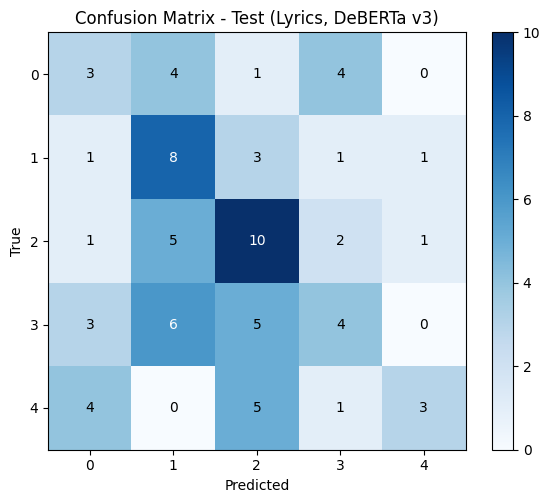

✅ Confusion matrix disimpan di: /content/drive/MyDrive/dataset_mirex/liriktrainY/confusion_matrix_lyrics_deberta_v3.png


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(all_test_labels, all_test_preds, labels=[0,1,2,3,4])

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation="nearest", cmap="Blues")  # 💙 biru
plt.title("Confusion Matrix - Test (Lyrics, DeBERTa v3)")
plt.colorbar()
ticks = np.arange(NUM_CLASSES)
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)
plt.xlabel("Predicted")
plt.ylabel("True")

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], "d"),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()

# simpan ke SAVE_DIR
CM_PATH = SAVE_DIR / "confusion_matrix_lyrics_deberta_v3.png"
plt.savefig(CM_PATH, dpi=300)
plt.show()

print("✅ Confusion matrix disimpan di:", CM_PATH)


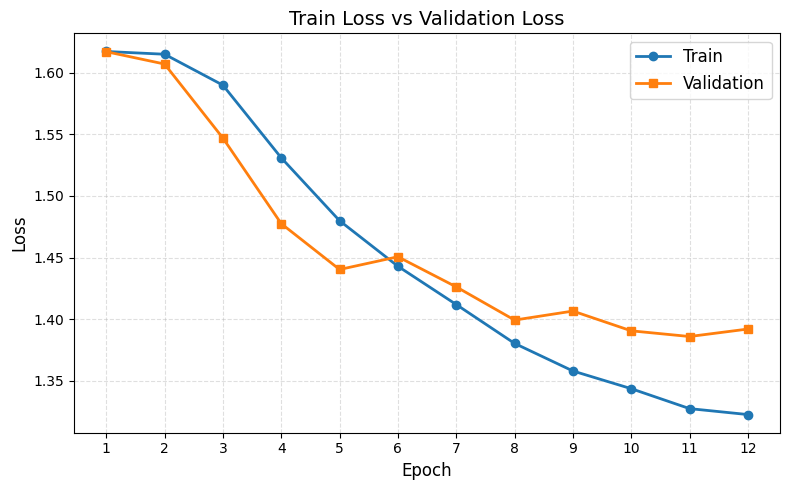

✅ Plot 'Train Loss vs Validation Loss' disimpan di: /content/drive/MyDrive/dataset_mirex/liriktrainY/curve_loss_lyrics_deberta_v3.png


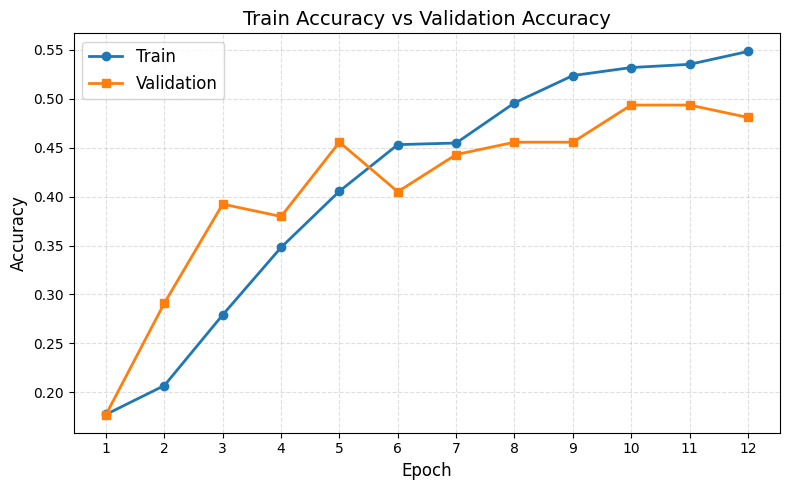

✅ Plot 'Train Accuracy vs Validation Accuracy' disimpan di: /content/drive/MyDrive/dataset_mirex/liriktrainY/curve_accuracy_lyrics_deberta_v3.png


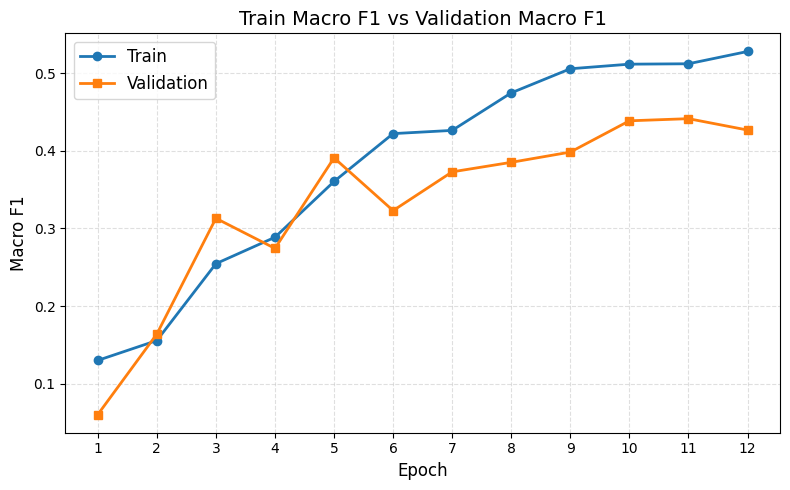

✅ Plot 'Train Macro F1 vs Validation Macro F1' disimpan di: /content/drive/MyDrive/dataset_mirex/liriktrainY/curve_macro_f1_lyrics_deberta_v3.png


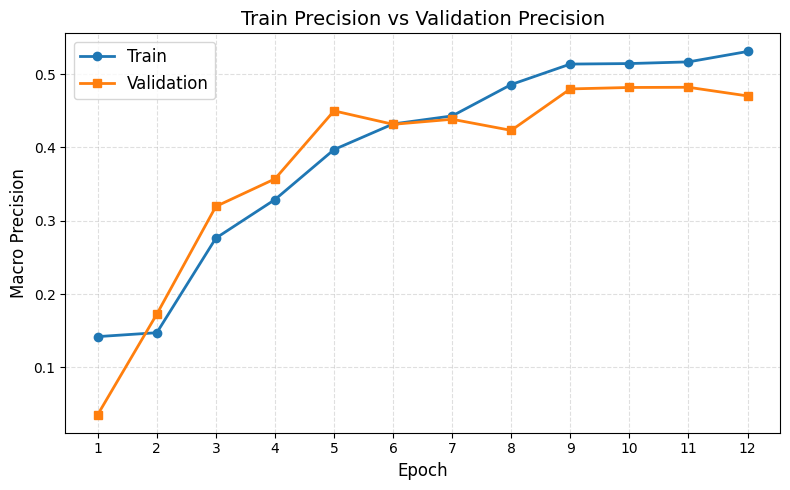

✅ Plot 'Train Precision vs Validation Precision' disimpan di: /content/drive/MyDrive/dataset_mirex/liriktrainY/curve_precision_lyrics_deberta_v3.png


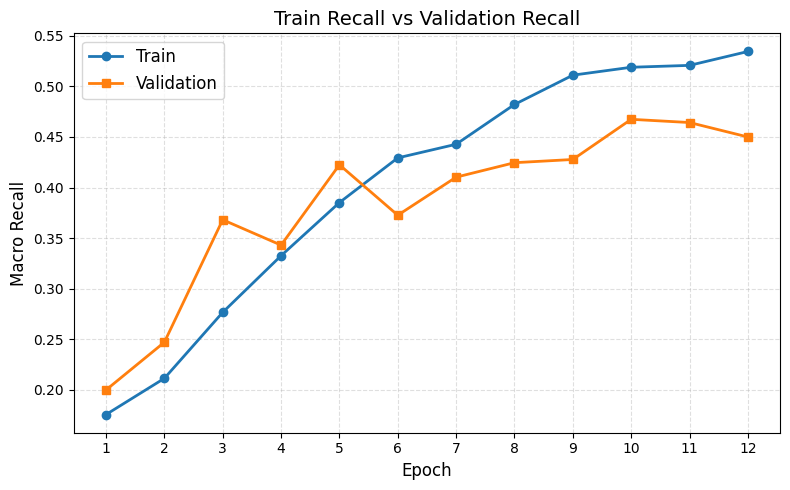

✅ Plot 'Train Recall vs Validation Recall' disimpan di: /content/drive/MyDrive/dataset_mirex/liriktrainY/curve_recall_lyrics_deberta_v3.png


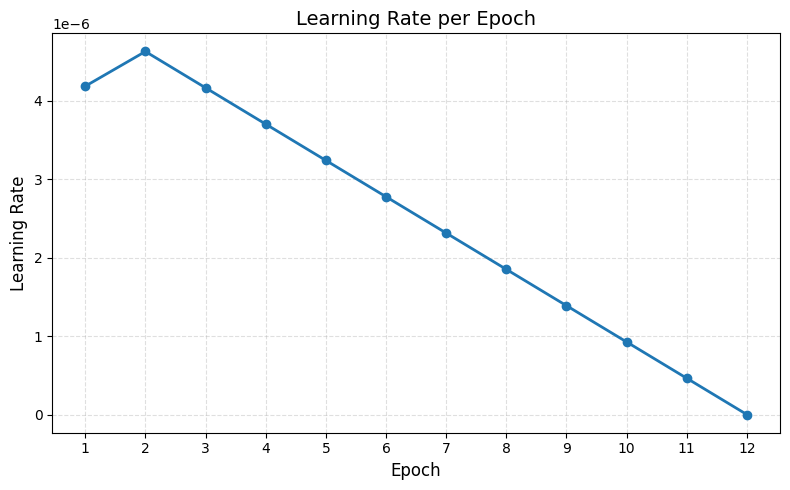

✅ LR curve disimpan di: /content/drive/MyDrive/dataset_mirex/liriktrainY/curve_lr_lyrics_deberta_v3.png
📈 Semua grafik perbandingan sudah ditampilkan & disimpan!


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_compare(train_values, val_values, title, ylabel, filename):
    plt.figure(figsize=(8,5))
    epochs = np.arange(1, len(train_values) + 1)

    plt.plot(epochs, train_values, marker='o', linewidth=2, label='Train')
    plt.plot(epochs, val_values, marker='s', linewidth=2, label='Validation')

    plt.title(title, fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(epochs)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend(fontsize=12)
    plt.tight_layout()

    out_path = SAVE_DIR / filename
    plt.savefig(out_path, dpi=300)
    plt.show()
    print(f"✅ Plot '{title}' disimpan di: {out_path}")


# =======================================
#               LOSS
# =======================================
plot_compare(
    history["train_loss"], history["val_loss"],
    "Train Loss vs Validation Loss",
    "Loss",
    "curve_loss_lyrics_deberta_v3.png"
)

# =======================================
#              ACCURACY
# =======================================
plot_compare(
    history["train_acc"], history["val_acc"],
    "Train Accuracy vs Validation Accuracy",
    "Accuracy",
    "curve_accuracy_lyrics_deberta_v3.png"
)

# =======================================
#                MACRO F1
# =======================================
plot_compare(
    history["train_f1"], history["val_f1"],
    "Train Macro F1 vs Validation Macro F1",
    "Macro F1",
    "curve_macro_f1_lyrics_deberta_v3.png"
)

# =======================================
#              PRECISION
# =======================================
plot_compare(
    history["train_prec"], history["val_prec"],
    "Train Precision vs Validation Precision",
    "Macro Precision",
    "curve_precision_lyrics_deberta_v3.png"
)

# =======================================
#               RECALL
# =======================================
plot_compare(
    history["train_rec"], history["val_rec"],
    "Train Recall vs Validation Recall",
    "Macro Recall",
    "curve_recall_lyrics_deberta_v3.png"
)

# =======================================
#          LEARNING RATE CURVE
# =======================================
plt.figure(figsize=(8,5))
epochs = np.arange(1, len(history["lr"]) + 1)
plt.plot(epochs, history["lr"], marker='o', linewidth=2)

plt.title("Learning Rate per Epoch", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Learning Rate", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.xticks(epochs)
plt.tight_layout()

LR_PATH = SAVE_DIR / "curve_lr_lyrics_deberta_v3.png"
plt.savefig(LR_PATH, dpi=300)
plt.show()

print("✅ LR curve disimpan di:", LR_PATH)
print("📈 Semua grafik perbandingan sudah ditampilkan & disimpan!")


In [ ]:
import pandas as pd
import numpy as np

epochs = np.arange(1, len(history["train_loss"]) + 1)

history_df = pd.DataFrame({
    "epoch": epochs,
    "train_loss": history["train_loss"],
    "val_loss": history["val_loss"],
    "train_acc": history["train_acc"],
    "val_acc": history["val_acc"],
    "train_f1": history["train_f1"],
    "val_f1": history["val_f1"],
    "train_prec": history["train_prec"],
    "val_prec": history["val_prec"],
    "train_rec": history["train_rec"],
    "val_rec": history["val_rec"],
    "lr": history["lr"],
})

print(history_df)

HISTORY_CSV_PATH = SAVE_DIR / "lyrics_deberta_v3_training_history.csv"
history_df.to_csv(HISTORY_CSV_PATH, index=False)
print("✅ Tabel history training disimpan di:", HISTORY_CSV_PATH)


    epoch  train_loss  val_loss  train_acc   val_acc  train_f1    val_f1  \
0       1    1.617420  1.617252   0.177340  0.177215  0.130010  0.060215   
1       2    1.615190  1.607221   0.206897  0.291139  0.155586  0.163970   
2       3    1.590049  1.547069   0.279146  0.392405  0.254596  0.313057   
3       4    1.531023  1.477526   0.348112  0.379747  0.288647  0.274289   
4       5    1.479897  1.440260   0.405583  0.455696  0.360484  0.390938   
5       6    1.442892  1.450603   0.453202  0.405063  0.422167  0.322972   
6       7    1.411798  1.426127   0.454844  0.443038  0.426312  0.372905   
7       8    1.380200  1.399156   0.495895  0.455696  0.474664  0.385179   
8       9    1.357787  1.406476   0.523810  0.455696  0.505729  0.398374   
9      10    1.343406  1.390419   0.532020  0.493671  0.511639  0.438673   
10     11    1.327202  1.385799   0.535304  0.493671  0.512153  0.441428   
11     12    1.322369  1.391877   0.548440  0.481013  0.527976  0.426782   

    train_p

In [ ]:
# 1) model
MODEL_PATH_RUNTIME = BEST_MODEL_PATH
MODEL_PATH_SAVE    = SAVE_DIR / "best_lyrics_bert.pt"

shutil.copy(MODEL_PATH_RUNTIME, MODEL_PATH_SAVE)
print("✅ Model disalin ke:", MODEL_PATH_SAVE)

# 2) CSV probs untuk fusion: id,true_label,prob_cluster_1..5
probs_array = all_test_probs  # (N_test, 5)

fusion_df = pd.DataFrame({
    "id": all_test_ids,
    "true_label": all_test_labels,
})
for i in range(NUM_CLASSES):
    fusion_df[f"prob_cluster_{i+1}"] = probs_array[:, i]

FUSION_CSV_PATH = SAVE_DIR / "lyrics_prob_for_fusion.csv"
fusion_df.to_csv(FUSION_CSV_PATH, index=False)
print("✅ Probabilitas fusion disimpan di:", FUSION_CSV_PATH)

# 3) CSV unimodal (pred + prob)
unimodal_df = pd.DataFrame({
    "id": all_test_ids,
    "true_label": all_test_labels,
    "pred_label": all_test_preds
})
for i in range(NUM_CLASSES):
    unimodal_df[f"prob_cluster_{i+1}"] = probs_array[:, i]

UNIMODAL_CSV_PATH = SAVE_DIR / "lyrics_unimodal_test_results.csv"
unimodal_df.to_csv(UNIMODAL_CSV_PATH, index=False)
print("✅ Hasil UNIMODAL disimpan di:", UNIMODAL_CSV_PATH)

print("\n🎉 Semua file penting lirik berhasil disimpan di folder:")
print(SAVE_DIR)
!ls -lh "$SAVE_DIR"


✅ Model disalin ke: /content/drive/MyDrive/dataset_mirex/liriktrainY/best_lyrics_bert.pt
✅ Probabilitas fusion disimpan di: /content/drive/MyDrive/dataset_mirex/liriktrainY/lyrics_prob_for_fusion.csv
✅ Hasil UNIMODAL disimpan di: /content/drive/MyDrive/dataset_mirex/liriktrainY/lyrics_unimodal_test_results.csv

🎉 Semua file penting lirik berhasil disimpan di folder:
/content/drive/MyDrive/dataset_mirex/liriktrainY
total 705M
-rw------- 1 root root 704M Dec 15 10:42 best_lyrics_bert.pt
-rw------- 1 root root  77K Dec 15 10:41 confusion_matrix_lyrics_deberta_v3.png
-rw------- 1 root root 170K Dec 15 10:42 curve_accuracy_lyrics_deberta_v3.png
-rw------- 1 root root 155K Dec 15 10:41 curve_loss_lyrics_deberta_v3.png
-rw------- 1 root root 124K Dec 15 10:42 curve_lr_lyrics_deberta_v3.png
-rw------- 1 root root 150K Dec 15 10:42 curve_macro_f1_lyrics_deberta_v3.png
-rw------- 1 root root 150K Dec 15 10:42 curve_precision_lyrics_deberta_v3.png
-rw------- 1 root root 167K Dec 15 10:42 curve_re